# Titanic_Data
> 타이타닉 데이터를 분석하여 탑승객의 환경이 생존과 어떤 관련이 있는지 알아 보고자 한다.

## 분석절차
1. EDA
  - target 피쳐 확인/ 분리
  - info(), shape, head() >> dataframe 타입별(수치형/object)
  - unique ID 피쳐 삭제

2. 결측치, 이상치 확인(1. 피쳐삭제 2. 채우기 = 대체 3.예측)
  - 결측값 대체(수치형:평균 / Object형:'None')
  - 확인방법 : Boxplot, histogram, IQR
  
3. 차트 그리기 준비
  - object형 시각화 --> 필요 시 수치형으로 변환
  
4. 피쳐 전처리(PreProcessing, Feature Engineering)
  - 수치형 피쳐로 변환(pd.getDummy)
  - 원 핫 인코딩(수치형)
  - 스케일(수치형:skew, 로그변환)/정규화(피쳐분포도 확인) : StandardScaler, MinMaxScaler, RobustScaler  
  
5. 수치형 피쳐 상관분석(결측X, 모든피쳐가 수치형)
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 Boxplot(Outlier)확인

6. 불필요한 피쳐 / 삭제

7. 학습모델 선정 / 평가

8. 튜닝 / 검증

In [18]:
# 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [19]:
# 데이터 불러오기 & 확인
df = pd.read_csv("ml_exam/titanic/kaggle_titanic_train.csv")
print(df.shape)
print(df.info())
print(df.head())

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

            

## 1. EAD
- info, shape, head() - dataframe
- 차트 : 일변량/ 이변량/ 다변량
- Unique 피쳐 삭제

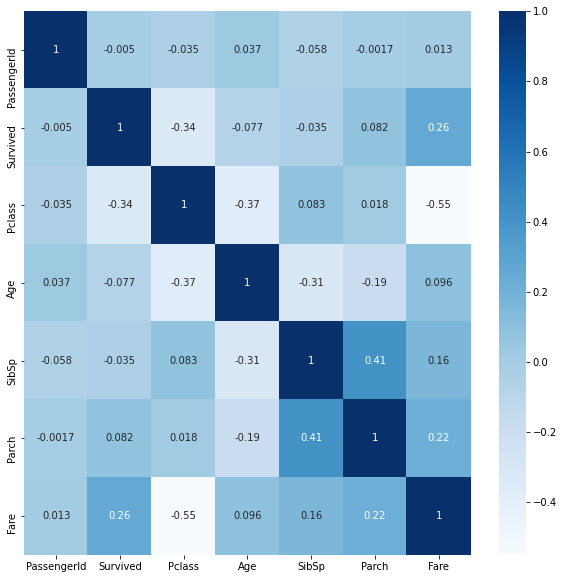

In [20]:
# 상관분석(가공전), sns.heatmap
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), annot = True, fmt = ".2g", cmap = "Blues")
plt.show()

> Fare, Pclass가 생존율과 연관이 있으므로 주의 있게 보자

In [21]:
# target feature 분리.
X = df.drop("Survived", axis = 1)
y = df["Survived"]
print(df["Survived"].value_counts())    # target feature가 균형적임을 알 수 있다.

0    549
1    342
Name: Survived, dtype: int64


In [22]:
# Delete Unique Feature
X.drop("PassengerId", axis = 1, inplace = True)

## 2. 결측처리, 이상치
- 삭제, 대체값, 예측

In [23]:
# age결측 >>> 예측(호칭별 평균 나이로 Age 결측데이터 처리)
# cabin >>> 항목 전체 삭제
X["Name2"] = X["Name"].str.extract("([A-Za-z]+)\.")
dict = X.groupby(by=["Name2"])[["Name2","Age"]].mean().astype(np.int32).to_dict()
fill_mean_func = lambda gname: gname.fillna(dict['Age'][gname.name])
X = X.groupby('Name2').apply(fill_mean_func)

# Age 구간화(원핫 인코딩 필요)
X["Age_cate"] = X["Age"].apply(lambda x : int(x//10))

X.drop("Cabin", axis = 1, inplace = True)

X["SP"] = X["SibSp"] + X["Parch"]

>- Name에서 앞부분을 추출해 Name2(호칭)를 생성한다.
>- 호칭별 평균나이를 계산하여 Age의 null값에 대체한다.
>- Age 데이터를 구간화 하여 Age_cate를 생성한다.

> 데이터 양이 적으므로 이상치 처리를 하지 않고 진행

## 3-1. 피쳐 전처리(PreProcessing, Feature Engineering) - Object 가공
- 라벨 인코딩, pd.getDummy() >>>object를 수치로 변환

In [24]:
# 성별 데이터 가공
X["Sex"] = X["Sex"].apply(lambda x: 0 if x == "female" else 1)
print(X["Age_cate"].head())

print(X.info())
X = pd.get_dummies(data=X , columns=["Age_cate"], prefix = "OH_Age_cate")  #, drop_first = True
print(X.info())
print(X.head())

0    2
1    3
2    2
3    3
4    3
Name: Age_cate, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
 9   Name2     891 non-null    object 
 10  Age_cate  891 non-null    int64  
 11  SP        891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 122.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891

## 3-2. 피쳐 전처리(PreProcessing, Feature Engineering) - Numeric 가공
- 원 핫 인코딩(수치형)  
- 스케일(수치형:skew, 로그변환)/정규화(피쳐분포도 확인) : StandardScaler, MinMaxScaler, RobustScaler

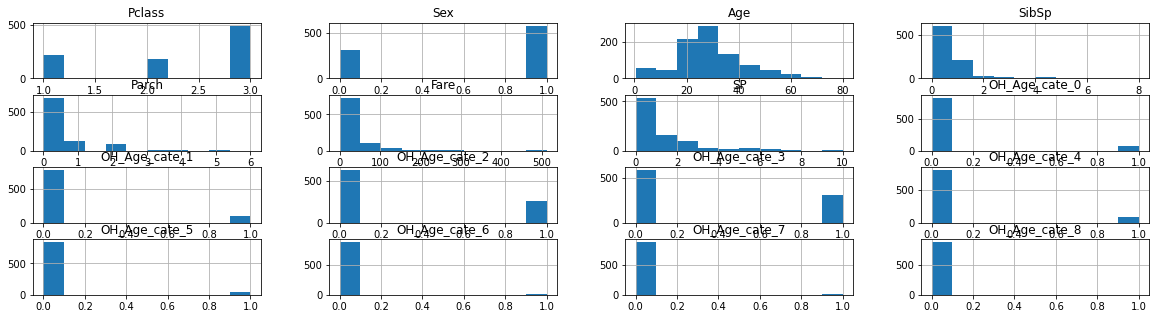

In [25]:
# 히스토그램 >> 편중확인 >> 스케일링
X.hist(figsize = (20, 5))
plt.show()

## 4. 불필요한 피쳐 삭제

In [27]:
replace_col = ["SibSp", "Parch","Name","Name2","Age"]    #SP=SibSp+Parch     OH_Age_cate_<--Name,Name2,Age
del_col = ["Ticket","Fare","Embarked"]  #Fare<--Pclass,SP   Embarked
replace_col = replace_col + del_col
X.drop(replace_col, axis=1, inplace=True)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Pclass         891 non-null    int64
 1   Sex            891 non-null    int64
 2   SP             891 non-null    int64
 3   OH_Age_cate_0  891 non-null    uint8
 4   OH_Age_cate_1  891 non-null    uint8
 5   OH_Age_cate_2  891 non-null    uint8
 6   OH_Age_cate_3  891 non-null    uint8
 7   OH_Age_cate_4  891 non-null    uint8
 8   OH_Age_cate_5  891 non-null    uint8
 9   OH_Age_cate_6  891 non-null    uint8
 10  OH_Age_cate_7  891 non-null    uint8
 11  OH_Age_cate_8  891 non-null    uint8
dtypes: int64(3), uint8(9)
memory usage: 68.0 KB
None


## 5. 분석하기 좋은 데이터가 갖춰짐 - 상관분석, Feature_importance
- 피처간 영향도, 피쳐의 중요도

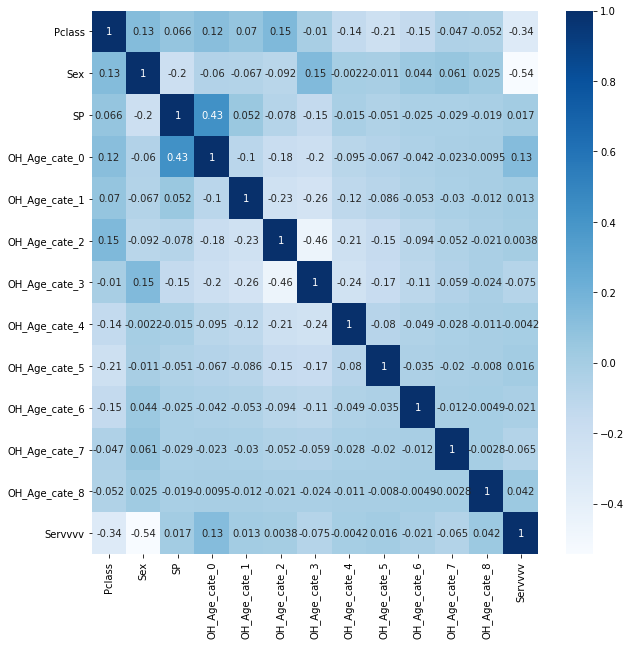

In [29]:
heat_df = X.copy()
heat_df["Servvvv"] = y
plt.figure(figsize=(10,10))
sns.heatmap(data=heat_df.corr(), annot = True, fmt = ".2g", cmap = "Blues")
plt.show()

 - Servived (target feature) 에 영향을 미치는 feature는 Pclass, Sex, OH_Age_cate_0 이다.

## 6. 학습모델 선정 / 학습 / 평가
- 분석 방법 : 회귀, 분류, 군집
- 분석 모델 : RandomForest(), DecisionTreeClassifier()
- 평가 모형 : f1, accuracy, auc, recall

--> 코딩 fit(), predict(), score()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)

dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

models = [dt_model, knn_model, rf_model]
for model in models :
    # fit : 학습하다
    model.fit(X_train, y_train)
    # predict : 시험
    y_pred = model.predict(X_test)
    # score : 예측 정확도 확인
    score = accuracy_score(y_test, y_pred)
    #-- f1, auc, accuracy, 교차검증
    #-- mse mae rmse
    #-- shilluet
    print(model.__class__)
    print(model.__str__(), ":" , score)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
DecisionTreeClassifier() : 0.7932960893854749
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
KNeighborsClassifier() : 0.7597765363128491
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
RandomForestClassifier() : 0.7932960893854749


>- kneighbors는 70% 중반의 정확도를 보였다.
>- DecisionTree와 RandomForest가 70% 후반의 좀 더 나은 정확도를 보였다.

## 7-1. 검증1 / 튜닝 
- 학습량 증가 : kFold(), cross_val_score()
- 학습량 증가 + 파라미터 튜닝 : GridSearchCV()

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True,  random_state=121)    # skf는 y의 label을 알아서 골고루 추출한다.(일반적으로 kfold보다 좋은 결과)
kf = KFold(n_splits=5,random_state=121,shuffle=True)
accuracy_score_list = []
f1_score_list = []
print(X.info())
# for (idx_train, idx_test) in kf.split(X):
# i = 0
for i, (idx_train, idx_test) in enumerate(kf.split(X)):  #skf.split(X, y)

    X_train, X_test = X.iloc[idx_train] , X.iloc[idx_test]
    y_train, y_test = y.iloc[idx_train] , y.iloc[idx_test]
    #~~~
    #---- 이하 학습 동일 --------------------
    # fit : 학습하다
    rf_model.fit(X_train, y_train)
    # predict : 시험
    y_pred = rf_model.predict(X_test)
    # score : 예측 정확도 확인
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_score_list.append(accuracy)
    f1       = f1_score(y_test, y_pred)
    f1_score_list.append(f1)
    print(i , ":" , accuracy, f1)
    # i = i+1
print("Kfold 평균 정확도:",np.mean(accuracy_score_list))
print("Kfold 평균 F1:",np.mean(f1_score_list))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Pclass         891 non-null    int64
 1   Sex            891 non-null    int64
 2   SP             891 non-null    int64
 3   OH_Age_cate_0  891 non-null    uint8
 4   OH_Age_cate_1  891 non-null    uint8
 5   OH_Age_cate_2  891 non-null    uint8
 6   OH_Age_cate_3  891 non-null    uint8
 7   OH_Age_cate_4  891 non-null    uint8
 8   OH_Age_cate_5  891 non-null    uint8
 9   OH_Age_cate_6  891 non-null    uint8
 10  OH_Age_cate_7  891 non-null    uint8
 11  OH_Age_cate_8  891 non-null    uint8
dtypes: int64(3), uint8(9)
memory usage: 68.0 KB
None
0 : 0.7988826815642458 0.7352941176470588
1 : 0.8370786516853933 0.7642276422764228
2 : 0.8370786516853933 0.7716535433070866
3 : 0.8651685393258427 0.8032786885245901
4 : 0.8033707865168539 0.7682119205298013
Kfold 평균 정확도: 0.8283158621555458
Kfold 평균 F

>- 평균 정확도 80% 초반에 형성 되었음, 데이터 증강의 효과가 있음
>- 평균 F1 70% 중반에 형성 되었음

In [41]:
from sklearn.model_selection import cross_val_score
score_list = cross_val_score(rf_model, X, y, scoring="accuracy", cv=5, verbose=0)
print("cross_val_score 평균 F1:",np.mean(score_list))

from sklearn.model_selection import cross_validate
my_score={"acc":"accuracy", "f1":"f1"}
score_list = cross_validate(rf_model, X, y, scoring=my_score, cv=5, verbose=0)
print("score_list------->", score_list)
score_df = pd.DataFrame(score_list)
print(score_df.head(10))
print("cross_validation 평균 정확도 : " , score_df["test_acc"].mean())
print("cross_validation 평균 f1 : " , score_df["test_f1"].mean())

cross_val_score 평균 F1: 0.8171050153788212
score_list-------> {'fit_time': array([0.11967969, 0.10740209, 0.10625362, 0.10575891, 0.10471535]), 'score_time': array([0.01000142, 0.01097131, 0.01099062, 0.0099771 , 0.00996637]), 'test_acc': array([0.79329609, 0.8258427 , 0.83146067, 0.79213483, 0.85955056]), 'test_f1': array([0.72992701, 0.76335878, 0.7826087 , 0.68376068, 0.80916031])}
   fit_time  score_time  test_acc   test_f1
0  0.119680    0.010001  0.793296  0.729927
1  0.107402    0.010971  0.825843  0.763359
2  0.106254    0.010991  0.831461  0.782609
3  0.105759    0.009977  0.792135  0.683761
4  0.104715    0.009966  0.859551  0.809160
cross_validation 평균 정확도 :  0.8204569706860838
cross_validation 평균 f1 :  0.7537630941363187


> Kfold와 비교했을 때 유의한 차이는 없다

In [44]:
# GridSearchCV(param ) --> 튜닝 전용
# 총 loop 횟수 : 12 = 1* 4* 3
my_hyper_param = {  "n_estimators"     :[100],  # 최대 300 ,
                    "max_depth"        :[3,5,7,9],
                    "min_samples_leaf" :[1,3,5],
                    "random_state"     :[121,]
                 }

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring="f1", refit=True, cv=5, verbose=0)
# #---- 이하 학습 동일 --------------------
# # fit : 학습하다
# gcv_model.fit(X_train, y_train)
# # predict : 시험
# print("best_estimator_", gcv_model.best_estimator_)
# print("best_params_",    gcv_model.best_params_)
# print("best_score_" ,    gcv_model.best_score_)

my_score={"acc":"accuracy", "f1":"f1"}
gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
#---- 이하 학습 동일 --------------------
# fit : 학습하다
gcv_model.fit(X_train, y_train)
# predict : 시험
print("best_estimator_", gcv_model.best_estimator_)
print("best_params_",    gcv_model.best_params_)
print("best_score_" ,    gcv_model.best_score_)

print("GridSearchCV 평균 정확도 : " , gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
print("GridSearchCV 평균 F1 : "    , gcv_model.cv_results_["mean_test_f1"].mean())

## 점수만 보고 싶을 때
# gcv_df = pd.DataFrame(gcv_model.cv_results_)
# print(gcv_df.info())
# print("GridSearchCV 평균 정확도 : " , gcv_df["mean_test_acc"].mean())
# print("GridSearchCV 평균 F1 : "    , gcv_df["mean_test_f1"].mean())

best_estimator_ RandomForestClassifier(max_depth=5, random_state=121)
best_params_ {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 121}
best_score_ 0.777741224645198
GridSearchCV 평균 정확도 :  0.8264002429495386
GridSearchCV 평균 F1 :  0.7535608559948025


## 7-2. 검증2
- 오차행렬(혼동행렬, confusion matrix)
- auc-roc curve
- 분석모델의 타당성